In [1]:
# load libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrds
%matplotlib inline

In [183]:
# functions that we will use in this notebook that you don;t need to worry about for now

def get_daily_wrds_single_ticker(ticker,conn,dividends=True):
    tickers = [ticker]
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = [permnos['permno'].unique().tolist()[0]]
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    # daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    # daily_returns=daily_returns['2000':]
    if dividends:
        daily_returns['D']=(daily_returns.ret-daily_returns.retx)*daily_returns.prc.abs().shift(1)
        daily_returns['P']=daily_returns.prc.abs()
        daily_returns=daily_returns[['date','P','D']].set_index('date').dropna()
    else:
        daily_returns=daily_returns[['date','ret']].set_index('date').dropna()    


    return daily_returns


def get_daily_wrds_multiple_ticker(tickers,conn):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret').dropna()    
    daily_returns=daily_returns[tickers]



    return daily_returns


# tickers = ['UNH']
# # Retrieve PERMNOs for the specified tickers
# permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
# permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
# permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]

# # Extract unique PERMNOs
# permno_list = permnos['permno'].unique().tolist()

# # Query daily stock file for the specified PERMNOs
# query = f"""
#     SELECT permno, date, ret,       
#     FROM crsp.dsf
#     WHERE permno IN ({','.join(map(str, permno_list))})
#     ORDER BY date
# """
# daily_returns = conn.raw_sql(query, date_cols=['date'])
# daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# # Pivot data to have dates as index and tickers as columns
# daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
# daily_returns=daily_returns['2000':]




# A Brief Overview 




* Define what are returns, which is the key variable of analysis in finance (and this class).
* Discuss how to think them of random variables 
* Discuss the key statistical "moments" that we will use to capture their behavior (i.e. how risky they are)
* Discuss the normal distribution specifically
* Define the concept of Excess returns



## What is a return?


* Lets say you paid $𝑃_𝑡$ in date $t$ for an asset

* In date $t+1$ the price is $𝑃_{𝑡+1}$  and you earn some dividend as well $𝐷_{𝑡+1}$

* Then we say that your return is

$$𝑅_{𝑡+1}=\frac{𝑃_{𝑡+1}+𝐷_{𝑡+1}−𝑃_𝑡}{𝑃_𝑡}$$

* It is the gain you made (everything that you go in date t+1), divided by how much you put in ( the price of the asset)


* This definition works for ANY asset that has a positive price

* This is the case for stocks, bonds, commodities, crypto, most real assets

* The return simply normalizes the "dollar gain" by the cost of the asset. 

* In practice there are many types of distributions that are economically like a dividend but have different names: cash dividends, stock dividends, capital gain distributions, rights offerings, acquisition  related distributions, splits

Lets start by loading Price and Dividend data on a single stock


In [181]:
conn = wrds.Connection()
df_UNH=get_daily_wrds_single_ticker('UNH',conn)
df_UNH

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[92655]


,P,D
date,,
1984-10-18,4.87500,0.0
1984-10-19,4.68750,0.0
1984-10-22,4.68750,0.0
1984-10-23,4.56250,0.0
1984-10-24,4.68750,0.0
...,...,...
2023-12-22,520.31000,0.0
2023-12-26,520.03003,0.0
2023-12-27,522.78998,0.0


In [ ]:
#How do we construct returns?


df_UNH['ret']=(df_UNH['P']+df_UNH['D'])/df_UNH['P'].shift(1)-1

df_UNH

,P,D,Ret
date,,,
1984-10-18,4.87500,0.0,NaN
1984-10-19,4.68750,0.0,-0.038462
1984-10-22,4.68750,0.0,0.000000
1984-10-23,4.56250,0.0,-0.026667
1984-10-24,4.68750,0.0,0.027397
...,...,...,...
2023-12-22,520.31000,0.0,0.000827
2023-12-26,520.03003,0.0,-0.000538
2023-12-27,522.78998,0.0,0.005307


Suppose that at the start of the sample we invested 1 dollar in this stock and got all the dividends and used to buy more of the stock, 

* how many dollars we would have at the end of the sample?

* What is the cumulative return on our investment?

* What is the annualized return?

* What is the dividend yield?




134.59749454136372
133.59749454136372
0.13320600988316555


<AxesSubplot:xlabel='date'>

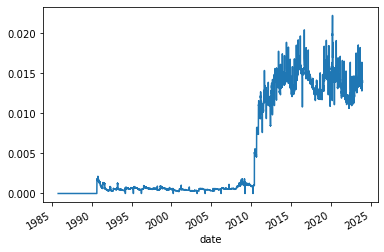

In [ ]:
print((df_UNH['ret']+1).prod())

print((df_UNH['ret']+1).prod()-1)


print((df_UNH['ret']+1).prod()**(252/df_UNH.shape[0])-1)


(df_UNH.D.rolling(252).sum()/df_UNH.P).plot()

Suppose we are now at the end of the sample 

* You have 1000 dollars invested in this stock in the end of the sample, the next day there’s a 16% chance your portfolio's value will fall below a certain amount. How would you estimate that value?

* Now suppose you want to know this value in one year? What is your estimate of this value?

* What is the expected value of your holdings in one year? How should you think about estimating this?





What plot can you do to have a sense of the distribution of 1 day returns? And 1 year returns?

What plot can you to give you a sense of these returns varying over time?

What drives these returns? Why do they vary over time?


## Decomposing Returns

* Returns of an individual stock can be driven by many things
  - Time-value of money. There are periods where you can get very high returns even in perfectly safe assets
  - Common factors, examples: all stocks went up because of a stronger economy, all stocks went down because of a financial crisis
  - Individual factors impacting the stock: A new drug/a new technology that the firm sells. Anything specific to the firm



### Striping the risk-free rate


* In this class we will do a lot of decomposing, but lets start by stripping down the "time-value of money" piece

* We first define an "<b>excess return</b>"： the return minus the risk-free rate 
 
 $$r_i^e=r_i-r_f$$
 
* We typically use the returns of a 3-month treasury bill to measure the risk-free rate $r_f$

* Conceptually you want to use the risk-free asset for the relevant holding period you are evaluating the asset returns, but for this class you can think of the "Fed Funds Rate" or the "3-month treasury-bill rate"


<AxesSubplot:xlabel='Date'>

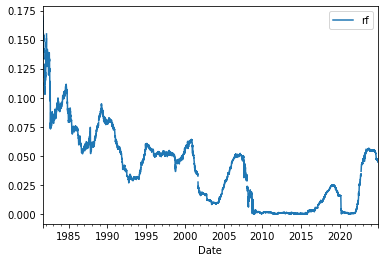

In [134]:
from pandas_datareader.data import DataReader
import datetime

# Define the date range
start_date = datetime.datetime(1960, 1, 1)  # Start date (adjust as needed)
end_date = datetime.datetime.now()          # End date

# Fetch the data from FRED for 3-month Treasury Bill rates (symbol: DGS3MO)
try:
    df_rf = DataReader("DGS3MO", "fred", start_date, end_date)
    df_rf.reset_index(inplace=True)
    df_rf.columns = ["Date", "rf"]
    df_rf.rf=df_rf.rf/100
    df_rf.set_index("Date", inplace=True)
except Exception as e:
    print(f"An error occurred: {e}")

df_rf.plot()

How do we interpret this rate?

Say if I invested in the tbill in 2005 how much money I would have in the end of 3 months? And in the end of the year?



Lets get another stock to play with and merge it together with our risk-free return


In [ ]:
df=get_daily_wrds_single_ticker('NVDA',conn,dividends=False)
df=df.merge(df_rf, left_index=True, right_index=True,how='left')
df

[47896]


,ret,rf
date,,
1969-03-06,-0.001938,NaN
1969-03-07,-0.009709,NaN
1969-03-10,-0.017255,NaN
1969-03-11,0.016129,NaN
1969-03-12,0.005952,NaN
...,...,...
2023-12-22,-0.000597,0.0544
2023-12-26,0.005914,0.0545
2023-12-27,0.005998,0.0544


Lets construct another column called 'rete' for excess returns

What is the trading interpretation of such series?

Is it the "return" to which strategy exactly?

How the historical distributions of ret and rete compare?
Are their averages similar? 
are their historical standard deviatons  similar? 
Do they have similar interpretation? 
Is the standard-deviation of risk-free rate useful to tell you the distribution of you returns in the end of 3 months? 

### Stripping the common factor


- We know that the overall market portfolio moves around, so it is natural to strip that market-wide movement from the stock returns

- Suppose f is this common factor, one possibility is to write

$$ret-f$$

- So we have a new asset "cleaned" of the common movement

- Will this work? When will it work?

- What is this common factor? 

- Is there only one factor?



* I will use the returns on the SPY etf as a market proxy

* This funds holds a market-capitalization weighted portfolio of the largest 500 US stocks (roughly)--this consists of about 85% of the total universe of investable US equities

* The press often cites the DOW as another proxy for the overall movement in stocks--but it is a terrible proxy, since is a equal weighted portfolio of 30 arbitrary chosen stocks. Please never ever use that

* If you really want to use a portfolio that tracks the entirety of the US stock market universe you can use VTI which is a ETF that holds market-capitalization weighted portfolio of all publicly traded US stocks. About 60 Trillion investment universe



In [202]:
df=get_daily_wrds_multiple_ticker(['SPY','WMT','JPM'],conn)
df

[47896, 55976, 84398]


ticker,SPY,WMT,JPM
date,,,
1993-02-01,0.007112,0.011516,0.009231
1993-02-02,0.002119,0.005693,0.003049
1993-02-03,0.010571,0.009434,0.012158
1993-02-04,0.004184,-0.003738,0.012012
1993-02-05,-0.000694,-0.011257,0.017804
...,...,...,...
2023-12-22,0.002010,0.011951,-0.000597
2023-12-26,0.004223,-0.001532,0.005914
2023-12-27,0.001808,0.009398,0.005998


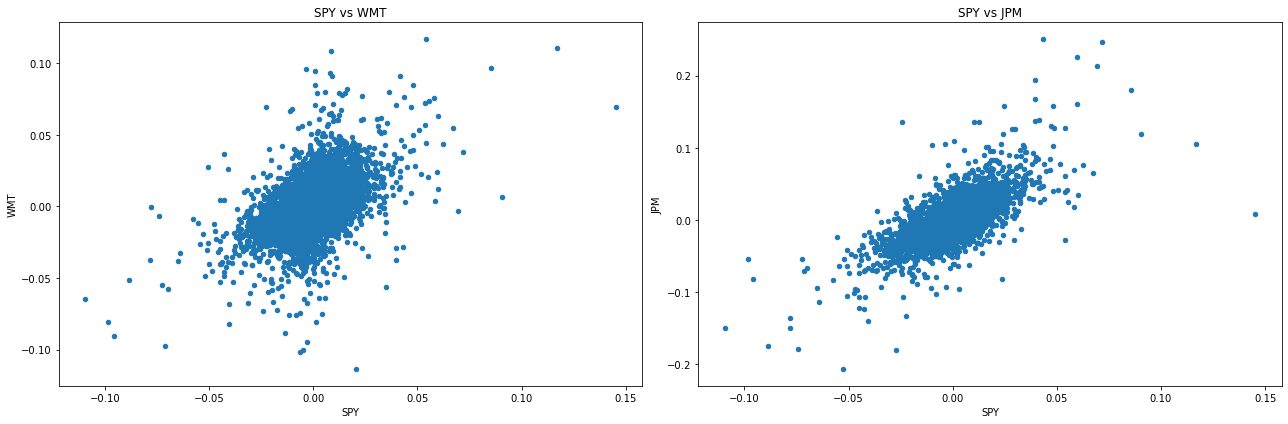

In [208]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm

def add_regression_line(ax, x, y):
    X = sm.add_constant(df[x])
    model = sm.OLS(df[y], X).fit()
    intercept, beta = model.params
    # ax.plot(df[x], intercept + beta * df[x], color='red')
    # ax.text(0.05, 0.95, f'Beta: {beta:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Add regression lines and beta coefficients
add_regression_line(axes[0], 'SPY', 'WMT')

add_regression_line(axes[1], 'SPY', 'JPM')
# Function to add regression line and beta coefficient

df.plot.scatter(x='SPY', y='WMT', ax=axes[0], title='SPY vs WMT')

# Scatter plot for SPY vs CSCO
df.plot.scatter(x='SPY', y='JPM', ax=axes[1], title='SPY vs JPM')

plt.tight_layout()
plt.show()

In [203]:
df[['WMTmspy','JPMmspy']]=df[['WMT','JPM']].subtract(df['SPY'],axis=0)
df

ticker,SPY,WMT,JPM,WMTmspy,JPMmspy
date,,,,,
1993-02-01,0.007112,0.011516,0.009231,0.004404,0.002119
1993-02-02,0.002119,0.005693,0.003049,0.003574,0.000930
1993-02-03,0.010571,0.009434,0.012158,-0.001137,0.001587
1993-02-04,0.004184,-0.003738,0.012012,-0.007922,0.007828
1993-02-05,-0.000694,-0.011257,0.017804,-0.010563,0.018498
...,...,...,...,...,...
2023-12-22,0.002010,0.011951,-0.000597,0.009941,-0.002607
2023-12-26,0.004223,-0.001532,0.005914,-0.005755,0.001691
2023-12-27,0.001808,0.009398,0.005998,0.007590,0.004190


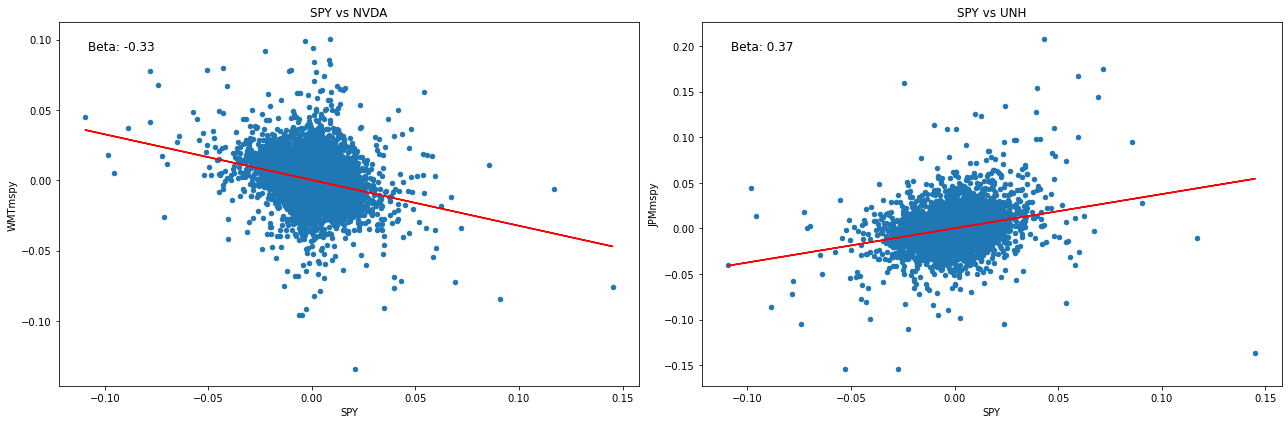

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm

def add_regression_line(ax, x, y):
    X = sm.add_constant(df[x])
    model = sm.OLS(df[y], X).fit()
    intercept, beta = model.params
    ax.plot(df[x], intercept + beta * df[x], color='red')
    ax.text(0.05, 0.95, f'Beta: {beta:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Add regression lines and beta coefficients
add_regression_line(axes[0], 'SPY', 'WMTmspy')

add_regression_line(axes[1], 'SPY', 'JPMmspy')
# Function to add regression line and beta coefficient

df.plot.scatter(x='SPY', y='WMTmspy', ax=axes[0], title='SPY vs WMT')

# Scatter plot for SPY vs CSCO
df.plot.scatter(x='SPY', y='JPMmspy', ax=axes[1], title='SPY vs JPM')

plt.tight_layout()
plt.show()

What is going on?

The "model" motivating our decomposition was

$$ r=f+\epsilon$$

But it seems that the residual still has factor exposure

* For stock 1, the residual is negatively correlated, so it seems tha we are taking out too much
* For stock 2, it is still positive, so we are taking out too little 


$$ret^e=\alpha+\beta MKT^e+\epsilon$$

$$(excess~return)=(intercept)+(stock~beta)*(excess~return~on~the~market)+ (idio~risk)$$


* What that looks like?

* look at scatter plot with market

* look at alphas, betas, indio vol, market vol by year

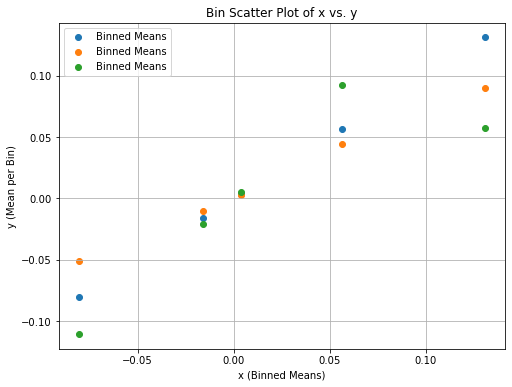

In [192]:
# Define number of bins
num_bins = 5

# Create bins for x
df['x_bin'] = pd.cut(df['SPY'], bins=num_bins, labels=False)

# Calculate mean x and mean y for each bin
bin_means = df.groupby('x_bin').mean().reset_index()

# Plot the bin scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bin_means['SPY'], bin_means.iloc[:,1], label="Binned Means")

plt.scatter(bin_means['SPY'], bin_means.iloc[:,2], label="Binned Means")
plt.scatter(bin_means['SPY'], bin_means.iloc[:,3], label="Binned Means")

plt.xlabel('x (Binned Means)')
plt.ylabel('y (Mean per Bin)')
plt.title('Bin Scatter Plot of x vs. y')
plt.grid(True)
plt.legend()
plt.show()

In [188]:
bin_means.iloc[:,0]

0      0
1      2
2      4
3      6
4      7
5      8
6     10
7     11
8     12
9     13
10    14
11    15
12    16
13    17
14    18
15    19
16    20
17    21
18    22
19    23
20    24
21    25
22    26
23    27
24    28
25    29
26    30
27    31
28    32
29    33
30    34
31    35
32    38
33    39
34    44
35    49
Name: x_bin, dtype: int64

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='date'>

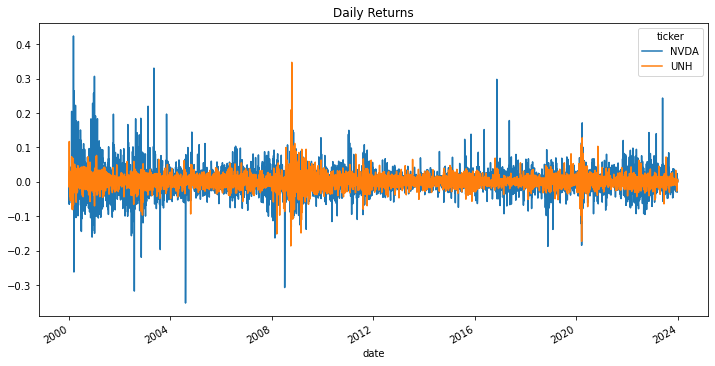

In [ ]:

daily_returns.loc['2023',     ['NVDA','UNH']].plot(figsize=(12, 6), title='Daily Returns')

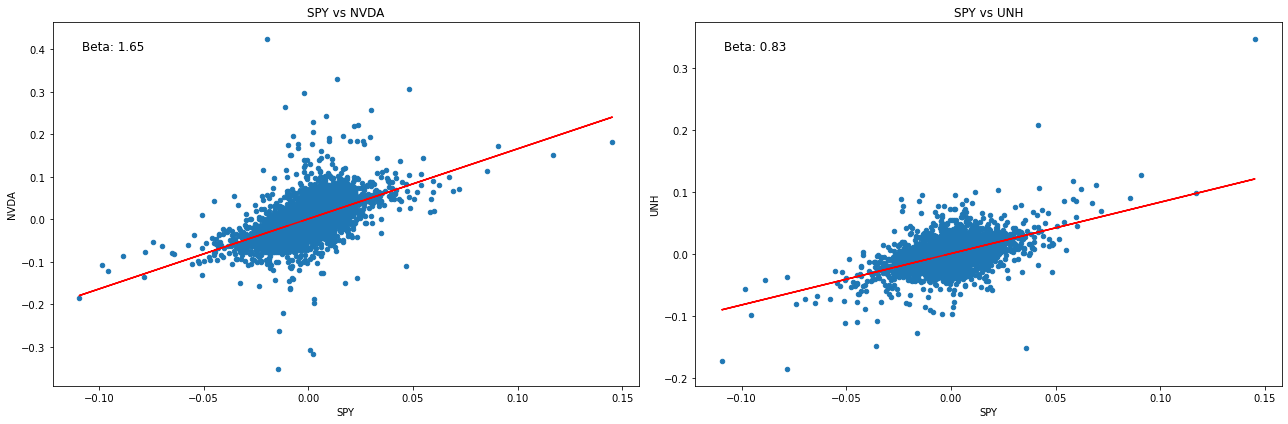

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm

def add_regression_line(ax, x, y):
    X = sm.add_constant(daily_returns[x])
    model = sm.OLS(daily_returns[y], X).fit()
    intercept, beta = model.params
    ax.plot(daily_returns[x], intercept + beta * daily_returns[x], color='red')
    ax.text(0.05, 0.95, f'Beta: {beta:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Add regression lines and beta coefficients
add_regression_line(axes[0], 'SPY', 'NVDA')

add_regression_line(axes[1], 'SPY', 'UNH')
# Function to add regression line and beta coefficient

daily_returns.plot.scatter(x='SPY', y='NVDA', ax=axes[0], title='SPY vs NVDA')

# Scatter plot for SPY vs CSCO
daily_returns.plot.scatter(x='SPY', y='UNH', ax=axes[1], title='SPY vs UNH')

plt.tight_layout()
plt.show()


# Scatter plot for SPY vs NVDA

In [2]:

#Online address of the file 
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
# load it using pandas
# the field "na_values=-99" is telling the function that numbers "-99" are code for a missing value
# THIS VARIES DATASET by DATASET!!!!
# In this case I know that to be the case
Data = pd.read_csv(url,na_values=-99)
# here we tell to pandas to interpret the DATE column as date type
Data['Date']=pd.to_datetime(Data['Date'])
# set the date as the index
Data=Data.set_index(['Date'])
#eep only the Market column
Data=Data[['MKT']]
# look at the first few observations
Data.head()

,MKT
Date,
1963-02-28,-0.0215
1963-03-31,0.0331
1963-04-30,0.0476
1963-05-31,0.0200
1963-06-30,-0.0177


**Comments**

- ".to_datetime" is pretty good at identifying how to interpret the data format, but you always have to check if it interpreted correct by inspecting it

- If it does not you will have to add the format manually 

**How Returns are distributed?**

We don't really know, but the normal distribution will be a useful approximation.
Sometimes goes spetacularly wrong, so you have to always be careful.
Normal distribution is nice because it only depends on the first two moments: Mean and Variance/Standard deviation.


Lets start by looking at the SAMPLE moments of the distribution of returns for the "market" portfolio
This is really the portfolio of all the stocks listed in the United States





**Mean and Standard Deviation**

In [3]:
# looking at it's mean
Data['MKT'].mean()*100

# what does this number mean?

0.9051777434312205

If I have invested 100 dollars in a random month in the sample, on average I would have 100.9 in month t+1 in the sample

A return of

$$\frac{100.9-100}{100}=0.9\%$$

In [ ]:
# looking at the market standard deviation

Data['MKT'].std()*100

# what does this number mean?

4.400314890674189

If I have invested 100 dollars in a random month in the sample, on average I would have at  least 100.9-2*4.4=92.1 with 97.5% probability (approximately).

Standard deviation gives you a notion of risk, because allow you to evaluate the probability of big losses (and also gains)

What do they tell you about your investment in a month outside of the sample?

**Histogram Plot**

This plots the frequency of return realization on each bin

it gives a sense of the HISTORICAL DISTRIBUTION of reuturns


<AxesSubplot:>

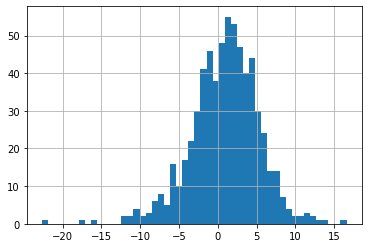

In [5]:

(Data.MKT*100).hist(bins=50)



**Time-Series plot**

The time-series plot shows us in each date what was the return on the asset in each month in the sample

<AxesSubplot:xlabel='Date'>

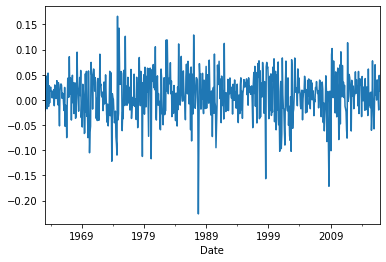

In [6]:
Data.MKT.plot()

## The Normal distribution

* Most of what we do does not depend on the assumption of normality

* But normal distributions are very useful in statistical tests

* And they are also not a bad approximation for return data at low frequency (monthly/year) 

* Probability that any random draw form a Normal distribution random variable $\tilde{x}$ is within $n=1$ standard deviation from the mean is 0.6826


$$Prob(E[\tilde{x}]-1\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+1\sigma(\tilde{x}))=0.6826$$

* $n=2,Prob(\cdot)=0.9550$

$$Prob(E[\tilde{x}]-2\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+2\sigma(\tilde{x}))=0.9550$$
* it is convenient to to transform a normally distributed r.v. into units of standard deviations from it's mean


$$\tilde{z}=\frac{\tilde{x}-E[\tilde{x}]}{\sigma(\tilde{x})}$$

* This follows the "standard" normal distribution, which has mean 0 and and standard deviation 1 

* can you show that is indeed the case that z has mean zero and standard devaiton 1? 

* This means that the normal distribution is completely characterized by it's first two moments

* This means that the investment problem is much more tractable too!

* Only two moments to worry about:

    * The expected return of the portfolio
    
    * it's variance
    
    * The probability of really bad tail events will follow immediately from these two! 

**How to evaluate whether returns are normal?**

## Decomposing Returns

### Excess Returns


* It is convenient to decompose the return earned in terms of what you earn due to
  1. compensation for waiting (time-value of money)
  2. compensation for bearing risk (risk premium)
 
* To do the decomposition, we will do the following:
  * We first define an "<b>excess return</b>"： the return minus the risk-free rate 
 
 $$r_i^e=r_i-r_f$$
 
  * We typically use the returns of a 3-month treasury bill to measure $R_f$
 
  * So the excess return of the market is

      $$r^e_{MKT}=r_{MKT}-r_f$$



### Alpha and Beta 


- Finance is all about striping

- Taking out the risk-free rate allows you to focus on the component of the returns that is due to "risk"

- Risk comes in all sort of forms

- Say you have bets on two different stocks, Netflix and Cotsco

- Plot Time-series, plot histogram, scatter plot



- We know that the overall market portfolio moves around, so it is natural to strip that market-wide movement from the stock returns


$$r_{i}^e=\alpha+\beta_i r^e_{MKT}+\epsilon_i$$

$$(excess~return)=(intercept)+(stock~beta)*(excess~return~on~the~market)+ (idio~risk)$$


* What that looks like?

* look at scatter plot with market

* look at alphas, betas, indio vol, market vol by year

In [17]:
(Data.MKT-Data.RF).mean()*100

0.5140340030911901

What does this mean?

Lets look at how much money one would have if they had invested 1 dollar in the market and kept reinvesting until the end of our sample

lets then compare with an investment in the risk-free rate

$$(1+r_1)(1+r_2)....(1+r_T)$$

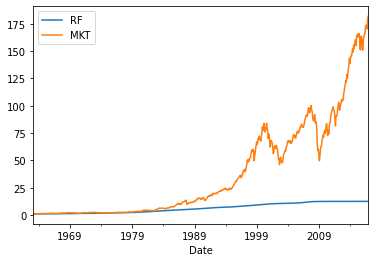

In [64]:
(1+Data[['RF','MKT']]).cumprod().plot()

This means that someone that invested 1 dollar in the market in 63, would have 182 dollars today.

A tota return of 182/1-1=18,100\%

If you invested in the risk-free rate you would have

12.5/1-1= 1,150\% which is a bit above the inflation in this same period

In [66]:
(1+Data[['RF','MKT']]).cumprod().tail(1)
(1+Data[['RF','MKT']]).prod()

RF      12.472682
MKT    181.954557
dtype: float64

**Why looking at things in terms of Excess returns is important ?**

1. All asset returns have both the risk-free component in it and the risk-premium component.

1. The risk-free component is directly observed-- for example in dollars it is convention to use the yield on the 3 month US treasury bill

     1.  The average risk-free rate of the last 30 years tells you nothing about the risk-less rate today BECAUSE you can directly observe what it is today. It is literally the rate of return that you get for sure if you buy a tbill and hold until maturity (3 months)--and this rate of return is know in advance because we know the final price of the tbill.

1. The particular instrument that you use to measure the risk-free rate might vary depending on a variety of complicated considerations

     - Is it funded instrument vs not funded (bills vs swaps)
     - Accessible to everyone or only some traders (bill vs fed funds)
     - Can you borrow at this rate (bills vs your broker lending rate)

1. the important point is that at any given moment you know the true risk-free rate. There is no point in estimating it


**Trading Interpretation**

* Excess returns have a nice trading interpretation.

* For example the excess return on the market (portfolio) is

$$R^{e,MKT}=R^{MKT}-R^F$$

* This is really a portfolio that has weights 1 on the market and -1 on the risk-free rate

* This type of portfolio is very important

* We call it a "self-financed portfolio" or "zero cost portfolio"

* The key is you are not putting any capital in it because you borrow 1 dollar to invest 1 dollar in the market (or in any other assets)

**Practical considerations and frictions** 

* we will discuss this later, but in practice you always have to put some capital on the trade

* some investors don't really need to put much like banks and dealers, but others like retail investors are asked to put much more.And often the amount of capital that you have to put on a "zero-cost" trade fluctuates with liquidity conditions (a lot during crises, not much during booms) 

* These portfolios are nevertheless super useful empirically to understand the data even if in the real world you cannot directly buy the zero cost portfolios without putting capital



OLD

  * i.e. how much more I would get if I invested in the market instead of a short-term risk-free U.S. treasury bond

  * We call the **Expected difference**, the <b>Risk-Premium</b>

      $$E[R_i^e]=E[R_i-R_f]$$

  * It is how much more you EXPECT to get by investing in asset $i$ instead of the risk-free asset

  * This is about the FUTURE, not the past. It is about what we expect at date t about the future t+1 date

   $$E_t[R_{t+1,i}^e]=E_t[R_{t+1,i}-R_{t,f}]$$

   $$E_t[R_{t+1,i}^e]=E_t[R_{t+1,i}]-R_{t,f}$$


  * When asset $i$ is the total market portfolio of US equities, we call this, the <b>Equity Risky Premium</b>

  **The Equity Risky Premium**

The expected difference in return earned by investing in the aggreagate stock market portfolio instead of the risk-free rate


  $$E[R_{MKT}-R_f]$$

One good estimate of it simply uses the sample mean

** A quick review of randomness and probability distributions **

**Random variables**

* We think of the return realization, the numbers plotted above, as a random variable, i.e., a variable that we are uncertain about it's realization. 

* Random variable is any thing that we don’t known

  * Outcome of dice throw, value of stock market in the end of the day, …
  * For example a dice outcome is a random variables with the following possible outcomes: (1,2,3,4,5,6)

* This uncertainty is fully described by the probability distribution associated with the random variable.





**What is a probability distribution?**

* A probability distribution describes the probability that each outcome is realized.
* It can be described by a Probability Density Function (pdf).
* For example, the pdf of a dice is (1,1/6) ,(2,1/6), (3,1/6), (4,1/6), (5,1/6), (6,1/6)
* It can also be described by the Cumulative Density Function(cdf)
* For a example, the cdf of a dice is (1,1/6) ,(2,2/6), (3,3/6), (4,4/6), (5,5/6), (6,6/6)
* A pdf or cdf fully describes the uncertainty we have with respect to a particular random variable
* Random variable is any thing that we don’t known
* Outcome of dice throw, value of stock market in the end of the day, …


**Moments**

* One way to summarize the information in a probability distribution is the moments

* Mean or expected value $E[𝑥]=∑𝑥_𝑖 𝑃𝑟𝑜𝑏(𝑥=𝑥_𝑖 )$  𝑜𝑟 $∫𝑥𝑓(𝑥)𝑑𝑥$  often uses µ as symbol

* The Variance $𝑣𝑎𝑟(𝑥)= ∑(𝑥_𝑖−𝐸[𝑥])^2 𝑃𝑟𝑜𝑏(𝑥=𝑥_𝑖 )$    𝑜𝑟 $∫(𝑥_𝑖−𝐸[𝑥])^2 𝑓(𝑥)𝑑𝑥 $ 
  
  * (Standard deviation $std(x)= \sqrt{𝑣𝑎𝑟(𝑥)}$)
  * measures average variability around the mean across successive drawings of x.
  * often use 𝜎 as a symbol for standard deviation and $\sigma^2$ for variance

